In [1]:
import os
import glob
import itertools
import json
import importlib

import matplotlib as mpl
import scipy.stats as spstats
import _pickle as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
# import statsmodels.api as sm
import pingouin as pg

In [2]:
import analyze2p.utils as hutils
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.plotting as pplot
import analyze2p.extraction.rois as rutils
import analyze2p.aggregate_datasets as aggr

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
import analyze2p.extraction.traces as traceutils
import analyze2p.objects.selectivity as sel

In [4]:
%matplotlib notebook

In [5]:
import importlib

In [6]:
pplot.set_plot_params(lw_axes=0.25, axis_labelsize=6, color='k', dpi=100)

In [7]:
aggregate_dir = '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-data'

# Load all data

In [8]:
visual_areas = ['V1', 'Lm', 'Li']
experiment = 'blobs'
traceid = 'traces001'
response_type = 'dff'
responsive_test = 'ROC'
responsive_thr = 0.05
responsive_str = '%s_%s-%.2f' % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, responsive_str])

sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['gratings'])].copy()
all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]

# Load trial metrics
trial_epoch='stimulus'
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 
print("Stimulus: %s (cell counts)" % experiment)
print(NDATA0[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())
# Get the cells
CELLS = aggr.get_all_responsive_cells(cells0, NDATA0) 

counts = aggr.count_n_cells(CELLS, name='n_cells', reset_index=True)
print(counts.groupby('visual_area').sum().to_markdown())
# Drop duplicates
u_dkeys = aggr.drop_repeats(counts, colname='n_cells')   
NDATA = pd.concat([g for (va, dk), g \
                   in NDATA0.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in u_dkeys], ignore_index=True)
if 'experiment' not in NDATA.columns:
    NDATA['experiment'] = experiment
# Final counts
final_ncells = aggr.count_n_cells(NDATA)
final_totals = aggr.get_final_cell_and_site_counts(final_ncells)
print("FINAL totals: %s (%s)" % (experiment, responsive_test))
print(final_totals.to_markdown())

SDF, incorrect_stim = aggr.check_sdfs(NDATA['datakey'].unique(), experiment='blobs',
                        images_only=False, rename=True,
                        return_incorrect=True, return_all=False)

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking mislabeled
Stimulus: blobs (cell counts)
|    |   visual_area |
|:---|--------------:|
| V1 |          1230 |
| Lm |          1098 |
| Li |           583 |


/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py:914: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for va, g in cells1.groupby(['visual_area']):
/tmp/ipykernel_2939508/3729947683.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(counts.groupby('visual_area').sum().to_markdown())


| visual_area   |   n_cells |
|:--------------|----------:|
| Li            |       583 |
| Lm            |      1098 |
| V1            |      1230 |
[V1] Animalid does not exist: JC078 


/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py:703: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cnts = final_cells.groupby(by='visual_area', axis=0).sum()


FINAL totals: blobs (ROC)
| visual_area   |   n_cells |   datakey |
|:--------------|----------:|----------:|
| Li            |       409 |        13 |
| Lm            |       709 |        10 |
| V1            |      1031 |         9 |


#### output dir

In [9]:
# Figure save dir
FIGDIR = os.path.join(aggregate_dir, 'FIGURES', 'sel_tol_MIGR')
if not os.path.exists(FIGDIR):
    os.makedirs(FIGDIR)
print(FIGDIR)

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/sel_tol_MIGR


In [10]:
va='V1'

example_rats = {'V1': '20190616_JC097_fov1',
                'Lm': '20190504_JC078_fov1',
                'Li': '20190422_JC076_fov1'}
#                 'Li': '20190614_JC091_fov1'}
dk = example_rats[va]
# session, animalid, fovn = p3.split_datakey_str(dk)
# traces, labels = p3.load_corrected_dff_traces(animalid, session, 'FOV%i_zoom2p0x' % fovn, 
#                                                 return_traces=True, return_labels=True)
data_fpath = traceutils.get_data_fpath(dk, experiment_name='blobs',
                                       rootdir=rootdir)
print(data_fpath)
raw_traces, labels, sdf, run_info = traceutils.load_dataset(data_fpath, 
                                                    trace_type='corrected',
                                                    rootdir=rootdir)
processed, trialmetrics = aggr.process_traces(raw_traces, labels, 
                        trace_type='dff', 
                        response_type='dff', trial_epoch='stimulus')

stim_on_frame = labels['stim_on_frame'].unique()[0]
nframes_on = labels['nframes_on'].unique()[0]
stim_on_sec = round(stim_on_frame/44.65, 1)

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_d1a2cd_traces001_a13a76_traces001_0a4432_traces001_6fc2ca_traces001_2449cf_traces001_70650b/data_arrays/corrected.npz
--- processed traces: dff


In [11]:
x0['response'].min()

NameError: name 'x0' is not defined

In [13]:
offset=False
with_lum = False

sdf = SDF[SDF['datakey']==dk] #SDF[dk].copy()
if with_lum:
    configs = sdf.index.tolist()
else:
    configs = sdf[sdf['morphlevel']!=-1].index.tolist()
sizes = list(sorted(sdf['size'].unique()))
morphlevels = list(sorted(sdf.loc[configs]['morphlevel'].unique()))
print(morphlevels)

x0 = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk) & (NDATA.config.isin(configs))].copy()

if offset:
    #x0['response'] = x0['response'] - x0.groupby(['cell'])['response'].transform('min')
    minv_global = NDATA[NDATA['datakey']==dk]['response'].min()
    x0['response'] = x0['response'] - minv_global
    
# curr_ixs = calculate_indices_for_neuraldf(x0[x0.config.isin(configs)], sdf, 
#                                        images_only=images_only)
# curr_ixs['visual_area'] = va
# curr_ixs['datakey'] = dk

rdf = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
rdf['size'] = sdf.loc[rdf['config']]['size'].values
rdf['morphlevel'] = sdf.loc[rdf['config']]['morphlevel'].values
rdf.head()

[0, 14, 27, 40, 53, 66, 79, 92, 106]


/tmp/ipykernel_2939508/314120860.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rdf = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)


,cell,config,response,size,morphlevel
0,0,config006,0.043369,10.0,0
1,0,config007,0.032694,20.0,0
2,0,config008,0.059416,30.0,0
3,0,config009,0.072709,40.0,0
4,0,config010,0.151419,50.0,0


In [14]:
rdf['response'].min()

-0.05057705754367962

In [15]:
min_vals = rdf.groupby('cell')['response'].min()
exclude_cells = min_vals[min_vals< -0.03].index.tolist()
exclude_cells

[0, 1, 51, 62, 224, 235, 249, 363, 385]

In [16]:
morph_curves = rdf.groupby(['cell']).apply(sel.get_x_curves_at_best_y,
                    x='morphlevel', y='size', normalize=False).reset_index(drop=True)
morph_curves

,cell,config,response,best_size,morphlevel
0,0,config010,0.151419,50.0,0
1,0,config015,0.061173,50.0,14
2,0,config020,0.098919,50.0,27
3,0,config025,0.002281,50.0,40
4,0,config030,0.056017,50.0,53
...,...,...,...,...,...
1660,431,config026,0.030414,10.0,53
1661,431,config031,0.037269,10.0,66
1662,431,config036,0.034470,10.0,79
1663,431,config041,0.042602,10.0,92


In [17]:
for rid, d_ in rdf.groupby('cell'):
    m_ = sel.get_x_curves_at_best_y(d_, x='morphlevel', y='size', normalize=False)
    if m_['response'].min() < -0.01:
        break

In [18]:
m_

,cell,config,response,best_size,morphlevel
94,2,config010,0.088854,50.0,0
99,2,config015,0.072976,50.0,14
104,2,config020,0.054968,50.0,27
109,2,config025,-0.011097,50.0,40
114,2,config030,0.088871,50.0,53
119,2,config035,0.032051,50.0,66
124,2,config040,0.001831,50.0,79
129,2,config045,0.010493,50.0,92
134,2,config050,-0.011672,50.0,106


In [19]:
-0.01/0.088

-0.11363636363636365

In [20]:
morph_curves['response'].min()

-0.04345719125010106

In [21]:
# import analyze2p.objec

In [22]:
# #### Generate morph tuning curves
# morph_curves = rdf.groupby(['cell']).apply(sel.get_x_curves_at_best_y, 
#                 x='morphlevel', y='size', normalize=True).reset_index(drop=True)
# morph_mat = morph_curves[['cell', 'response', 'morphlevel']].pivot(columns='cell', index='morphlevel')

# print(morph_curves['size'].unique())

# #### Calculate morph selectivity index
# morph_ixs = rdf.groupby(['cell']).apply(sel.assign_morph_ix, at_best_other=True).rename(columns={0:'morph_ix'})
# sorted_morph_ixs = morph_ixs.sort_values(by='morph_ix', ascending=False)

# #### Generate size tuning curves
# size_curves = rdf.groupby(['cell']).apply(sel.get_x_curves_at_best_y, 
#                                            x='size', y='morphlevel', normalize=True).reset_index(drop=True)
# size_mat = size_curves[['cell', 'response', 'size']].pivot(columns='cell', index='size')

# #### Calculate size tolerance
# size_tols = rdf.groupby(['cell']).apply(sel.assign_size_tolerance, at_best_other=True).rename(columns={0:'size_tol'})
# sorted_size_tols = size_tols.sort_values(by='size_tol', ascending=False)

# #### Calculate sparseness
# sparse_ixs = rdf[['cell', 'response']].groupby(['cell']).apply(sel.assign_sparseness).rename(columns={0:'sparseness'})

# #### Aggregate
# best_ixs = pd.concat([size_tols, morph_ixs, sparse_ixs], axis=1).reset_index()
# best_ixs.index=best_ixs['cell']
# best_ixs.head()

In [23]:
#### Generate tuning curves

rdf = rdf[~rdf['cell'].isin(exclude_cells)].copy()

morph_curves, size_curves = sel.get_object_tuning_curves(rdf, sort_best_size=False,
                                                normalize=True, return_stacked=True)
#### Calculate morph selectivity index
morph_ixs = rdf.groupby(['cell']).apply(sel.assign_morph_ix, 
                                        at_best_other=True, name='morph_sel')
morph_ixs.index = morph_ixs.index.droplevel(1)
sorted_morph_ixs = morph_ixs.sort_values(by='morph_sel', ascending=False)
#### Calculate size tolerance
size_tols = rdf.groupby(['cell']).apply(sel.assign_size_tolerance, 
                                        at_best_other=True, name='size_tol')
size_tols.index = size_tols.index.droplevel(1)
sorted_size_tols = size_tols.sort_values(by='size_tol', ascending=False)
#### Aggregate
best_ixs = pd.concat([size_tols, morph_ixs], axis=1).reset_index()
best_ixs.index=best_ixs['cell']

max_morph=max(morphlevels)
best_ixs['best_morphlevel_normed'] = best_ixs['best_morphlevel']/float(max_morph)
best_ixs.head()

,cell,size_tol,best_morphlevel,morph_sel,best_size,best_morphlevel_normed
cell,,,,,,
2,2,0.339537,53.0,0.587511,50.0,0.500000
9,9,0.362837,14.0,0.360534,20.0,0.132075
11,11,0.366570,79.0,0.352886,10.0,0.745283
12,12,0.569956,14.0,0.448541,30.0,0.132075
15,15,0.391547,0.0,0.563972,50.0,0.000000


In [24]:
morph_curves['response'].min()

0.0

# Set colors

In [25]:
roi_labels = ['high', 'low'] # 'all']
# roi_colors = ['black',  'black'] #, 'k']
# roi_styles = ['-', '--']
roi_colors = ['cornflowerblue',  'orange'] #, 'k']
roi_styles = ['-', '-']


size_labels = [int(s) for s in sorted(sdf['size'].unique())]
morph_labels = [int(s) for s in sorted(sdf['morphlevel'].unique())]
rank_order=False


# V1: 20190616_JC097_fov1
# -----------------------
if va=='V1' and dk=='20190616_JC097_fov1':
    plot_rois = [217, 388] #, 107] #131] #104] #sorted_morph_ixs.iloc[0:topn].index.tolist()
    #rois_plot_sz = [405, 388] #405#[362, 405] #, 107] #107] #sorted_size_tols.iloc[0:topn].index.tolist()
    #rois_plot_sz = [217, 388]
    cmaps=['cool', 'cool_r']

elif va=='Lm' and dk=='20190504_JC078_fov1':
    # Li: 20190422_JC076_fov1
    # -----------------------
    plot_rois = [194, 185] #24]
    # rois_plot_sz = [294, 76] 
    #rois_plot_sz = [194, 185]
    cmaps=['cool', 'cool_r']
    
elif va=='Li' and dk=='20190422_JC076_fov1':
    # Li: 20190422_JC076_fov1
    # -----------------------
    #rois_plot_mp = [119, 76]
    # rois_plot_sz = [294, 76] 
    #rois_plot_sz = [119, 76] 
    plot_rois = [119, 76] 
    #rois_plot_sz = [293, 76] 
    #rois_plot_mp = rois_plot_sz
    cmaps=['cool', 'cool_r']

elif va=='Li' and dk=='20190614_JC091_fov1':
    # Li: 20190422_JC076_fov1
    # -----------------------
    #rois_plot_mp = [119, 76]
    # rois_plot_sz = [294, 76] 
    #rois_plot_sz = [119, 76] 
    plot_rois = [304, 234] #[331, 234] 
    #rois_plot_mp = rois_plot_sz
    cmaps=['cool', 'cool_r']
    
    
# Othres.
# # # Li: 20190607_JC091_fov
# rois_plot_mp = [304, 343]
# rois_plot_sz = [304, 343]

# # # Li: 20190607_JC091_fov
# rois_plot_mp = [343, 331] # 331] #, 107] #131] #104] #sorted_morph_ixs.iloc[0:topn].index.tolist()
# rois_plot_sz = [304, 234] #[362, 405] #, 107] #107] #sorted_size_tols.iloc[0:topn].index.tolist()

# # Li: 20191105_JC117_fov1
# rois_plot_mp = [67, 38] # 331] #, 107] #131] #104] #sorted_morph_ixs.iloc[0:topn].index.tolist()
# rois_plot_sz = [78, 19] #[362, 405] #, 107] #107] #sorted_size_tols.iloc[0:topn].index.tolist()

lw=0.25


In [26]:
import analyze2p.utils as util

In [27]:
importlib.reload(sel)

<module 'analyze2p.objects.selectivity' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py'>

<IPython.core.display.Javascript object>


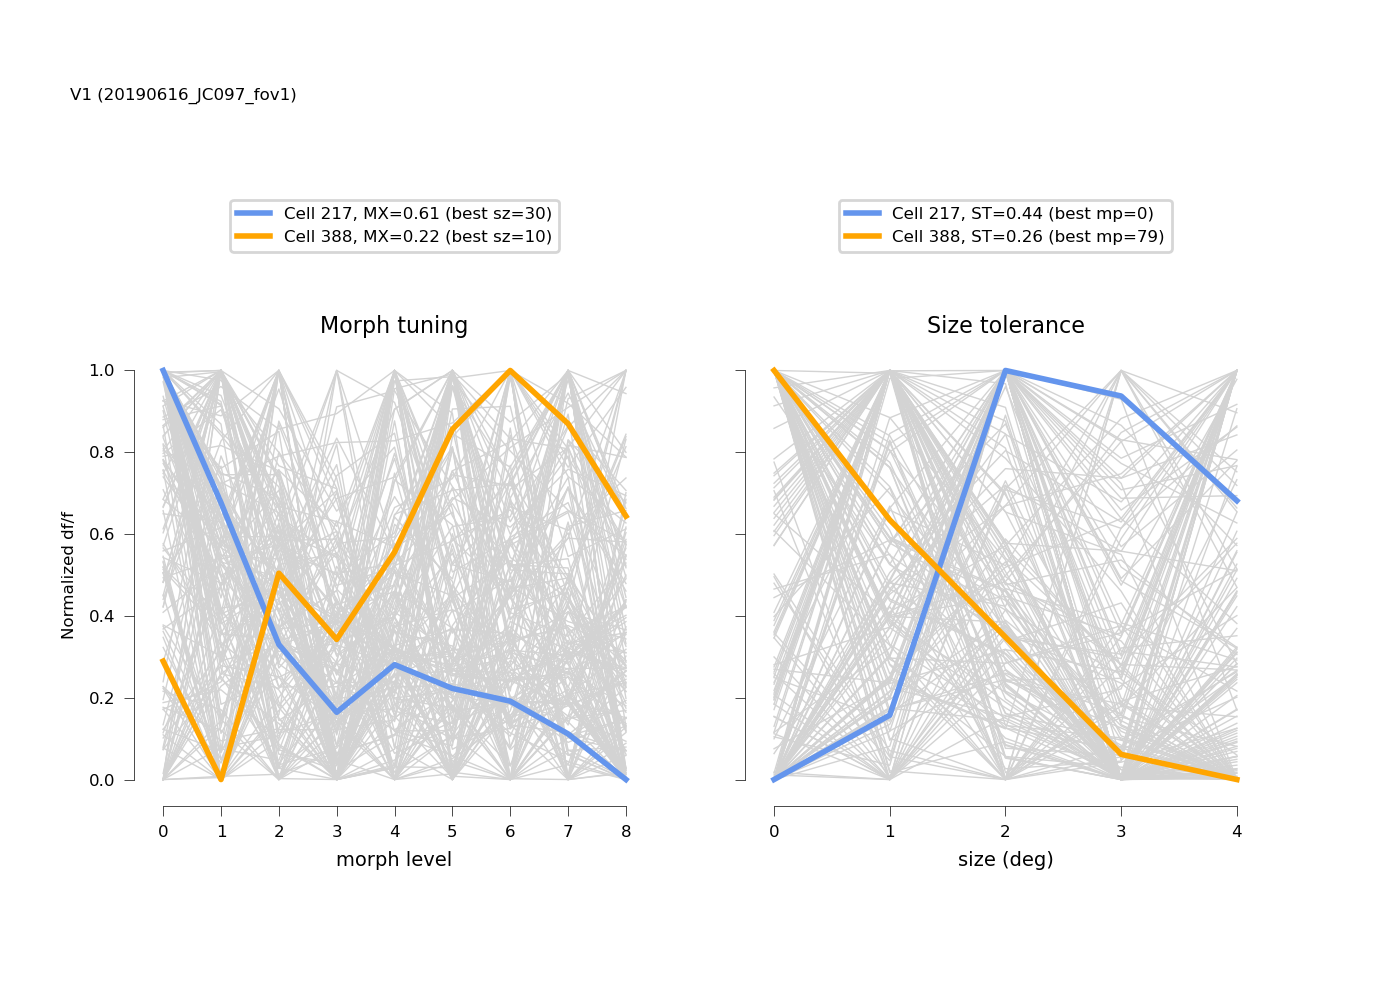

In [28]:
%matplotlib notebook
#### Generate tuning curves
rank_order_size=False
morph_mat, size_mat = sel.get_object_tuning_curves(rdf, 
                                            sort_best_size=rank_order_size,
                                            normalize=True, return_stacked=False)
# plot.
fig, axn = pl.subplots(1,2, figsize=(7,5), dpi=100,sharey=True)
fig.patch.set_alpha(1)
ax=axn[0]
rois_mp_labels=None
if plot_rois is not None:
    rois_mp_labels = ['Cell %i, MX=%.2f (best sz=%i)' % \
                     (rid, best_ixs.loc[rid]['morph_sel'], 
                     int(best_ixs.loc[rid]['best_size'])) for rid in plot_rois]
ax = sel.plot_overlaid_tuning_curves(morph_mat, rank_order=False, ax=ax,
                                rois_plot=plot_rois, roi_styles=roi_styles,
                                roi_colors=roi_colors,
                                roi_labels=rois_mp_labels, lw=0.5, lc='lightgray',
                                roi_lw=2)
xlabel = 'morph level'
ax.set_xlabel(xlabel, fontsize=7)
ax.set_ylabel('Normalized df/f')
ax.set_title("Morph tuning")
# Size Tolerance
ax=axn[1]
roi_sz_labels=None
if plot_rois is not None:
    roi_sz_labels = ['Cell %i, ST=%.2f (best mp=%i)'
                % (rid, best_ixs.loc[rid]['size_tol'], 
                  best_ixs.loc[rid]['best_morphlevel']) for rid in plot_rois]
ax = sel.plot_overlaid_tuning_curves(size_mat, rank_order=rank_order_size, ax=ax,
                                rois_plot=plot_rois, roi_styles=roi_styles,
                                roi_colors=roi_colors,
                                roi_labels=roi_sz_labels, lw=0.5, lc='lightgray',
                                roi_lw=2)
xlabel = 'Rank-ordered size pref.' if rank_order else 'size (deg)'
ax.set_xlabel(xlabel, fontsize=7)
ax.set_title("Size tolerance")
sns.despine(offset=2, trim=True)
fig.text(0.05, 0.9, '%s (%s)' % (va, dk), fontsize=6)
pl.subplots_adjust(wspace=0.2, left=0.1, right=0.9, top=0.65, bottom=0.2)

#pplot.label_figure(fig, '%s|%s - %s' % (data_id, va, dk))
#pplot.label_figure(fig, data_id)
figname = 'aggr_tuning_curves_rid%s__%s_%s' \
                % ('_'.join([str(i) for i in sorted(plot_rois)]), va, dk)
#pl.savefig(os.path.join(examples_dir, '%s.svg' % figname))
#pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
#print(examples_dir, figname)

### Traces

In [29]:
def smooth_timecourse(in_trace, win_size=41):
    #smooth trace
    win_half = int(round(win_size/2))
    trace_pad = np.pad(in_trace, ((win_half, win_half)), 'reflect') # 'symmetric') #'edge')

    smooth_trace = np.convolve(trace_pad, np.ones((win_size,))*(1/float(win_size)),'valid')
    
    return smooth_trace

def smooth_traces_trial(gg, win_size=5, colname='trial'):
    smoothed_ = smooth_timecourse(gg, win_size=win_size)
    return pd.Series(smoothed_)

In [30]:
dk

'20190616_JC097_fov1'

In [31]:
use_plain_colors=True
# [V1] 20190616_JC097_fov1 
# -------------------------------------------
# Tolerant:  217, 388
# 388 (best=10): mid=30, worst=50 | "cool_r"
# 217 (best=30): mid=20, worst=10 | "cool"
if va=='V1' and dk=='20190616_JC097_fov1':
    if use_plain_colors:
        roi_cmap= {217: 'k', 388: 'k'}
    else:
        roi_cmap= {217: 'cool', 388: 'cool_r'}
    ranked_sizes = {388: {'mid': 30, 'worst': 50},
                    217: {'mid': 20, 'worst': 10}}

elif va=='Lm' and dk=='20190504_JC078_fov1':
    # [Lm] 20190504_JC078_fov1 
    # ------------------------------------------- _
    # 194 (best=50): mid=40, worst=30 | "cool"
    # 185 (best=50): mid=40, worst=30 | "cool_r"
    if use_plain_colors:
        roi_cmap= {194: 'k', 185: 'k'}
    else:
        roi_cmap= {194: 'cool', 185: 'cool_r'}
    ranked_sizes = {194: {'mid': 40, 'worst': 30},
                    185: {'mid': 40, 'worst': 30}}
    
elif va=='Li':
    if dk=='20190422_JC076_fov1':
        # [Li] 20190422_JC076_fov1 
        # -------------------------------------------
        # Tolerant:  119, _
        # 119 (best=10): mid=30, worst=50 | "cool"
        # 76 (best=10): mid=30, worst=40 | "cool_r"
        if use_plain_colors:
            roi_cmap = {119: 'k', 76: 'k'}
            #roi_cmap = {293: 'k', 76: 'k'}
        else:
            roi_cmap= {119: 'cool', 76: 'cool_r'}
            #roi_cmap= {293: 'cool', 76: 'cool_r'}
            
        ranked_sizes = {293: {'mid': 30, 'worst': 10},
                        119: {'mid': 30, 'worst': 50},
                        76: {'mid': 30, 'worst': 40}}
    elif dk=='20190614_JC091_fov1':
        # [Li] 20190614_JC091_fov1 #JC076_fov1 
        # -------------------------------------------
        if use_plain_colors:
            roi_cmap = {304: 'k', 234: 'k'}
        else:
            roi_cmap= {304: 'cool', 234: 'cool_r'}
        ranked_sizes = {331: {'mid': 40, 'worst': 30},
                        304: {'mid': 20, 'worst': 10},
                        234: {'mid': 30, 'worst': 50}}



# [Li] 20190422_JC076_fov1, 293 (best=50): mid=30, worst=10 | "Greens"

# [Li] 20190614_JC091_fov1
# -------------------------------------------
# Tolerant:  304, 234, 331, 343
# 304 (best=50, mid=20, worst=10) | "Greens"
# 234 (best=30, mid=30, worst=50) | "Purples"
# 343 (best=50, mid=40, worst=10) | "Purples"

In [32]:
morph_curves['size'] = morph_curves['best_size']

In [45]:
plot_rois

[217, 388]

In [54]:
rois_ = plot_rois #rois_plot_sz #list(roi_cmap.keys())

curr_roi_ix = 0
curr_roi_col = roi_colors[curr_roi_ix]

rid = rois_[curr_roi_ix] # 194
print(rid)
curr_cmap= roi_cmap[rid] #'cool_r'
# mid_v = ranked_sizes[rid]['mid']
# worst_v = ranked_sizes[rid]['worst']
# ==============================================================================

# x='morphlevel'; y='size';
# fbest = int(morph_curves[morph_curves['cell']==rid][y].unique())
# print(fbest)
# curves_mid = rdf.groupby(['cell']).apply(sel.get_x_curves_at_given_size,
#                     x='morphlevel', y='size', val_y=mid_v, normalize=True).reset_index(drop=True)

# curves_worst = rdf.groupby(['cell']).apply(sel.get_x_curves_at_given_size,
#                     x='morphlevel', y='size', val_y=worst_v, normalize=True).reset_index(drop=True)

# fmid = int(curves_mid[curves_mid['cell']==rid][y].unique())
# fworst = int(curves_worst[curves_worst['cell']==rid][y].unique())
# ranked_hues = [fbest, fmid, fworst]
# print(ranked_hues)

fill_sem=False
index_to_plot='morph_ix'
if use_plain_colors:
    colors=[curr_cmap]*3
else:
    colors=sns.color_palette(curr_cmap, n_colors=3*2) #[0::2]
hue_ = 'morphlevel' if index_to_plot=='size_tol' else 'size'
subplot_par = 'size' if hue_=='morphlevel' else 'morphlevel'


217


#### plot bw

In [55]:
with_lum = False
lum_str = '_wLUM' if with_lum else ''

#sdf = SDF[dk].copy()
if with_lum:
    curr_cfgs = sdf.index.tolist()
else:
    curr_cfgs = sdf[sdf['morphlevel']!=-1].index.tolist()
sizes = list(sorted(sdf['size'].unique()))

#best_cfgs = sdf[(sdf[hue_]==fbest) & (sdf.morphlevel!=-1)].index.tolist()

rtraces = labels.copy()
rtraces['dff'] = processed[rid].copy()
currt = rtraces[rtraces.config.isin(curr_cfgs)].copy()

currt['size'] = sdf.loc[currt['config']]['size'].values
currt['morphlevel'] = sdf.loc[currt['config']]['morphlevel'].values


In [56]:
morphlevels
M = morphlevels[0:]
#M.append(morphlevels[0])
print(M)

[0, 14, 27, 40, 53, 66, 79, 92, 106]


<IPython.core.display.Javascript object>


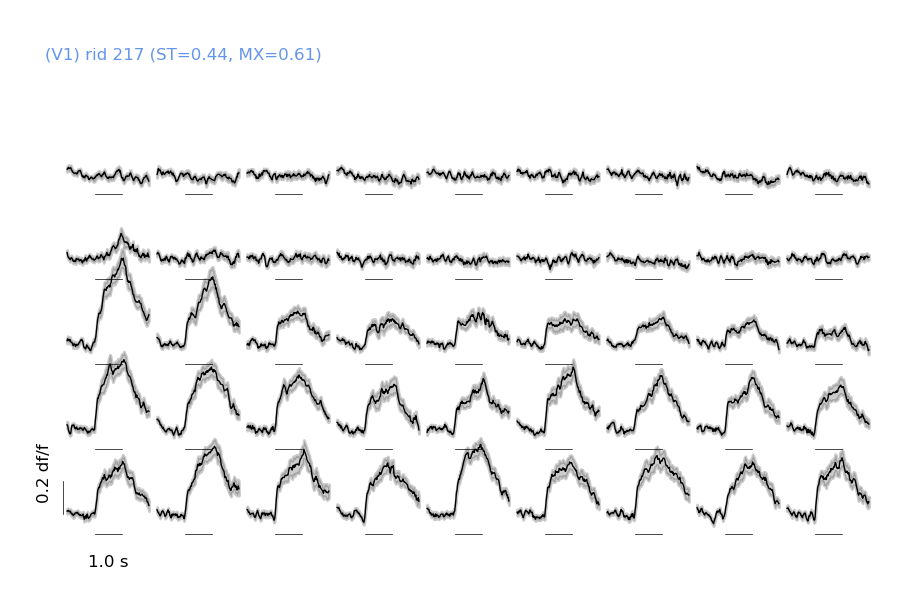

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/sel_tol_MIGR/traces_V1_20190616_JC097_fov1_cell217


In [57]:
fill_sem=True
mean_only=False
ls = '-'

fig, axn = pl.subplots(5, len(morphlevels), figsize=(4.5, 3), 
                       sharex=True, sharey=True)
for (sz, mp), g in currt.groupby(['size', 'morphlevel']):
    si = sizes.index(sz) #sizes[::-1].index(sz)
    mi = M.index(mp)
    ax=axn[si, mi]
    ax.patch.set(alpha=0)
    #ax.set_title('{}, {}'.format(mp, sz))
    t_df = g.groupby(['trial'])['dff'].apply(smooth_traces_trial, win_size=5).unstack().T
    mean_t = np.nanmean(t_df, axis=1)
    std_t = np.nanstd(t_df, axis=1)
    sem_t = spstats.sem(t_df, axis=1, nan_policy='omit')

    if not mean_only:
        if fill_sem:
            #ax.fill_between(np.arange(0, len(mean_t)), mean_t-std_t, mean_t+std_t, alpha=0.2, color='k')
            ax.fill_between(np.arange(0, len(mean_t)), mean_t-sem_t, mean_t+sem_t, alpha=0.2, color='k')
        else:
            ax.plot(t_df, lw=0.1, color='gray', alpha=1) #'k')
    ax.plot(mean_t, lw=.5, c='k', linestyle=ls) #, label='%s %i' % (hue_, curr_hue))

    # format
    ax.set_xticks([stim_on_frame, stim_on_frame+nframes_on])
    ax.set_yticks([0.0, 0.1, 0.2])
    ax.tick_params(which='both', axis='both', size=0)
    if (mi==0 and si==len(sizes)-1):
        sns.despine(trim=True, ax=ax) #, bottom=True, left=True, ax=ax)
        ax.set_xticklabels([])
        ax.set_yticklabels(['', '0.2 df/f', ''], rotation=90)
        ax.set_xlabel('%s s' % (stim_on_sec))
        ax.set_ylabel('0.2 df/f')
    else:
        ax.set_yticks([])
        sns.despine(trim=True, ax=ax, left=True)
        ax.set_yticklabels([])
        ax.set_xticklabels([])

#     ax.set_ylim([0.0, 0.7])
#sns.despine(trim=True, offset=0.2)
pl.subplots_adjust(left=0.07, right=0.97, wspace=0, hspace=-.3)

fig.text(0.05, 0.9, '(%s) rid %i (ST=%.2f, MX=%.2f)' \
             % (va, rid, best_ixs.loc[rid]['size_tol'],
                best_ixs.loc[rid]['morph_sel']), color=curr_roi_col)
    
#p3.label_figure(fig, '%s|%s - %s' % (data_id, va, dk))
figname = 'traces%s_%s_%s_cell%03d' % (lum_str, va, dk, rid)
pl.savefig(os.path.join(FIGDIR, '{}.svg'.format(figname)))
print(os.path.join(FIGDIR, figname))

In [52]:
FIGDIR

'/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/sel_tol_MIGR'